In [ ]:
# This is a notebook to fix what's wrong with the integration

In [23]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
# import pickle as pkl
# import math
import pandas as pd
import time
from tkinter import filedialog
from PIL import ImageTk, Image
import tkinter as tk
# from tkinter import ttk
# import multiprocessing as mp
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
# , NavigationToolbar2Tk
import webbrowser


# Feed Specifications
feed_comp_a = 2.353  # kmol / m^3
feed_flow = 1  # m^3 / s
feed_temp = 362  # K

# Jacket Specifications
jacket_temp_in = 150  # K
jack_feed_flow = 0.1  # m^3 / s

history_df = pd.DataFrame(columns=['time', 'bulk_a_comp', 'reactor_temp', 'jacket_temp_out'])
def run_simulation():
    """
    This function runs the simulation of the CSTR in dynamic mode.

    :return:
    """
    
    global history_df
    bulk_comp_a = 2.353 # kmol / m^3
    reactor_temp = 362.4 # K
    temperate_jacket_out = 345.69 # K
    # feed_flow, feed_a_comp, feed_temp, jack_feed_flow
    sol = scipy.integrate.solve_ivp(system_of_equations, [0, 0.1],
                                    [bulk_comp_a, reactor_temp, temperate_jacket_out],
                                    args=(feed_flow, feed_comp_a, feed_temp, jack_feed_flow), first_step=0.0001)
    history_df = pd.DataFrame(
        {'time': 0, 'bulk_a_comp': sol.y[0], "reactor_temp": sol.y[1], "jacket_temp_out": sol.y[2]})

    last_time = 0.1

    for i in range(0, 10000):

        sol = scipy.integrate.solve_ivp(system_of_equations, [last_time, last_time + 0.1],
                                        [history_df['bulk_a_comp'].iloc[-1], history_df['reactor_temp'].iloc[-1],
                                         history_df['jacket_temp_out'].iloc[-1]], args=(feed_flow, feed_comp_a, feed_temp, jack_feed_flow), method="BDF")
        history_df = pd.concat([history_df, pd.DataFrame(
            {"time": last_time + 0.1, 'bulk_a_comp': sol.y[0], "reactor_temp": sol.y[1], "jacket_temp_out": sol.y[2]})])

        last_time = last_time + 0.1
        
        if i % 100 == 0:
            print(i)
            
            print(history_df)
            
    for i in range(0, 10000):

        sol = scipy.integrate.solve_ivp(system_of_equations, [last_time, last_time + 0.1],
                                        [history_df['bulk_a_comp'].iloc[-1], history_df['reactor_temp'].iloc[-1],
                                         history_df['jacket_temp_out'].iloc[-1]], args=(feed_flow, feed_comp_a + 0.5, feed_temp, jack_feed_flow), method="BDF")
        history_df = pd.concat([history_df, pd.DataFrame(
            {"time": last_time + 0.1, 'bulk_a_comp': sol.y[0], "reactor_temp": sol.y[1], "jacket_temp_out": sol.y[2]})])

        last_time = last_time + 0.1
        
        if i % 100 == 0:
            print(i)
            
            print(history_df)



In [24]:
def system_of_equations(t, y, feed_flow, feed_a_comp, feed_temp, jack_feed_flow):
    # y[0] = bulk_a_comp
    # y[1] = reactor_temp
    # y[2] = temperature_jacket_out

    # Constants
    reactor_volume = 10  # m^3
    k1 = 0.85  # rate constant for reaction 1
    jacket_volume = 0.1  # m^3
    heat_transfer_coefficient = 0.1  # W / m^2 K
    area_of_transfer = 0.1  # m^2

    # constants that later should be dynamically changed
    feed_flow = feed_flow  # m^3 / s
    feed_a_comp = feed_a_comp  # mol / m^3
    feed_temp = feed_temp  # K

    energy_activation = 0.1  # J / mol
    R = 8.314  # J / mol K

    enthalpy_change = 0.1  # J / mol
    density = 0.1  # kg / m^3
    heat_capacity = 0.1  # J / kg K

    jacket_flow = jack_feed_flow  # m^3 / s

    # Differential Equations
    dCadt = (((feed_flow / reactor_volume) * feed_a_comp) - ((feed_flow / reactor_volume) * y[0])
             - k1 * np.exp(-energy_activation / (R * y[1])) * y[0])

    dTdt = ((((feed_flow / reactor_volume) * (feed_temp - y[1])) +
            ((enthalpy_change / (density * heat_capacity)) * k1 * np.exp(-energy_activation / (R * y[1])) * y[0]))
            - ((heat_transfer_coefficient * area_of_transfer / (density * heat_capacity * reactor_volume)) *
               (y[1] - y[2])))

    dTjdt = ((jacket_flow / jacket_volume) * (jacket_temp_in - y[2]) +
             (heat_transfer_coefficient * area_of_transfer / (density * heat_capacity * jacket_volume)) * (y[1] - y[2]))

    return [dCadt, dTdt, dTjdt]


In [25]:
run_simulation()

0
   time  bulk_a_comp  reactor_temp  jacket_temp_out
0   0.0     2.353000    362.400000       345.690000
1   0.0     2.352800    362.401829       345.687143
2   0.0     2.350801    362.420104       345.658851
3   0.0     2.330917    362.601573       345.402030
4   0.0     2.162207    364.121008       344.583515
0   0.2     2.162207    364.121008       344.583515
1   0.2     2.154326    364.191217       344.589300
2   0.2     2.146475    364.261087       344.597677
3   0.2     2.070666    364.931562       344.835528
4   0.2     1.997816    365.571507       345.189424
5   0.2     1.990675    365.634072       345.228608
100
    time  bulk_a_comp  reactor_temp  jacket_temp_out
0    0.0     2.353000    362.400000       345.690000
1    0.0     2.352800    362.401829       345.687143
2    0.0     2.350801    362.420104       345.658851
3    0.0     2.330917    362.601573       345.402030
4    0.0     2.162207    364.121008       344.583515
..   ...          ...           ...              ...

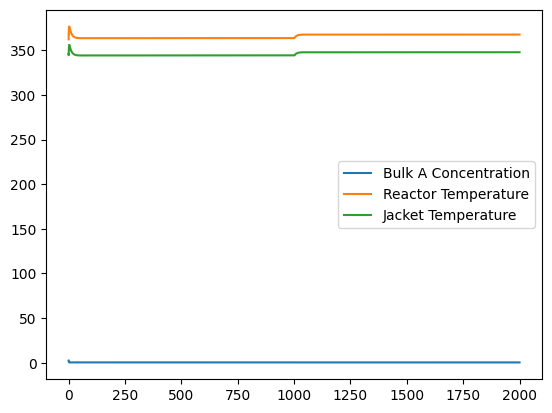

In [26]:
# plot the results

plt.plot(history_df['time'], history_df['bulk_a_comp'], label='Bulk A Concentration')
plt.plot(history_df['time'], history_df['reactor_temp'], label='Reactor Temperature')
plt.plot(history_df['time'], history_df['jacket_temp_out'], label='Jacket Temperature')
plt.legend()  
plt.show()